<a href="https://colab.research.google.com/github/soobook/TensorFlow-DL/blob/main/code/TF17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 17회차: DNN-GAN을 활용한 손글씨 모방하기 (3) - 모델 학습 및 이미지 생성


In [ ]:
# 시각화 준비
!pip install koreanize_matplotlib
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

## 16회차 DNN-GAN 전반부 구현

In [ ]:
# -------------------- 1. 라이브러리 로딩 --------------------
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import tensorflow_probability as tfp

# -------------------- 2. 데이터 준비 --------------------
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32") - 127.5) / 127.5
x_train = x_train.reshape((-1, 784))
BUFFER_SIZE = 60000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# -------------------- 3. 모델 정의 --------------------
def make_generator_model():
    return tf.keras.Sequential([
        tf.keras.Input(shape=(100,)), # 명시적 Input layer
        layers.Dense(256, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(784, activation='tanh') # 출력은 784 = 28x28
    ])

def make_discriminator_model():
    return tf.keras.Sequential([
        tf.keras.Input(shape=(784,)), # 명시적 Input layer
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid') # 출력은 실수 하나 (진짜/가짜 확률)
    ])

# -------------------- 4. GAN 클래스 정의 --------------------
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super().compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal([batch_size, 100])

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise)
            real_logits = self.discriminator(real_images)
            fake_logits = self.discriminator(fake_images)
            d_loss_real = self.loss_fn(tf.ones_like(real_logits), real_logits)
            d_loss_fake = self.loss_fn(tf.zeros_like(fake_logits), fake_logits)
            d_loss = (d_loss_real + d_loss_fake) / 2
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        noise = tf.random.normal([batch_size, 100])
        with tf.GradientTape() as tape:
            fake_images = self.generator(noise)
            fake_logits = self.discriminator(fake_images)
            g_loss = self.loss_fn(tf.ones_like(fake_logits), fake_logits)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

## 17회차 다음부터

In [ ]:
# -------------------- 5. FID / IS 계산 --------------------
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))

def get_inception_features(images):
    images = tf.image.resize(images, [75, 75])
    images = preprocess_input(images)
    return inception(images, training=False)

def calculate_fid(real_images, fake_images):
    # InceptionV3 특성 추출
    act1 = get_inception_features(real_images)
    act2 = get_inception_features(fake_images)

    # 평균 및 공분산 계산
    mu1, sigma1 = tf.reduce_mean(act1, axis=0), tfp.stats.covariance(act1)
    mu2, sigma2 = tf.reduce_mean(act2, axis=0), tfp.stats.covariance(act2)
    # 평균 차이의 제곱합 (Euclidean 거리)
    ssdiff = tf.reduce_sum(tf.square(mu1 - mu2))

    # 수치 안정성을 위해 아주 작은 값 더하기
    eps = 1e-6
    sigma1 += eps * tf.eye(sigma1.shape[0])
    sigma2 += eps * tf.eye(sigma2.shape[0])
    # 행렬 곱의 제곱근 계산
    covmean = sqrtm((sigma1 @ sigma2).numpy())
    # 복소수 값이 나올 경우 실수 부분만 사용
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # FID 계산: 평균 거리 + 공분산 trace 거리
    fid = ssdiff + tf.linalg.trace(sigma1 + sigma2 - 2 * tf.convert_to_tensor(covmean))

    return fid

def calculate_inception_score(images, splits=10):
    preds = tf.nn.softmax(get_inception_features(images))
    scores = []
    N = preds.shape[0]
    for i in range(splits):
        part = preds[i * N // splits: (i + 1) * N // splits]
        py = tf.reduce_mean(part, axis=0)
        kl = part * (tf.math.log(part + 1e-10) - tf.math.log(py + 1e-10))
        kl_sum = tf.reduce_mean(tf.reduce_sum(kl, axis=1))
        scores.append(tf.exp(kl_sum).numpy())
    return np.mean(scores)

In [ ]:
# -------------------- 6. 5 에폭마다 생성된 이미지 저장 함수 --------------------
def generate_and_save_images(model, epoch, seed):
    # 고정된 latent seed로 Generator에서 이미지 생성
    predictions = model(seed, training=False) # 16개의 그림 생성
    # 생성 이미지의 픽셀값을 [-1, 1] → [0, 1] 범위로 정규화 (시각화용)
    predictions = (predictions + 1) / 2.0

    # 4x4 그리드 형태의 이미지 출력을 위한 figure 객체 생성
    fig = plt.figure(figsize=(4, 4))
    # 생성된 각 이미지를 서브플롯에 하나씩 출력
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)  # 4행 4열 중 i+1 번째 위치에 이미지 배치
        # 28x28 이미지로 reshape, 흑백 표시
        plt.imshow(predictions[i].numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')  # 축 눈금 숨기기

    # 저장 폴더가 없으면 생성
    os.makedirs("generated", exist_ok=True)
    # 이미지 저장: 에폭 번호를 네 자리로 표현하여 파일 이름 지정
    plt.savefig(f"generated/image_epoch_{epoch:04d}.png")
    # 현재 figure 객체 닫기 (메모리 누수 방지)
    plt.close()

In [ ]:
# -------------------- 7. 콜백 정의 --------------------
class ImageEvalCallback(tf.keras.callbacks.Callback):
    def __init__(self, generator, seed, real_images):
        # 생성된 이미지를 평가할 Generator 모델
        self.generator = generator
        # 5 에폭마다 생성할 16개 이미지의 노이즈 벡터 100, 즉 모양은 (16, 100)
        self.seed = seed
        # 실제 이미지 샘플 (FID 계산 시 사용)
        self.real_images = real_images

        # 에폭별 FID 점수를 저장할 리스트
        self.fid_scores = []
        # 에폭별 IS (Inception Score)를 저장할 리스트
        self.is_scores = []
        # 에폭별 판별자(Discriminator) 손실값 저장 리스트
        self.epoch_d_losses = []
        # 에폭별 생성자(Generator) 손실값 저장 리스트
        self.epoch_g_losses = []

        # 현재 에폭에서 배치마다 누적되는 판별자(Discriminator) 손실 저장 리스트 (평균 내기 위함)
        self._temp_d_losses = []
        # 현재 에폭에서 배치마다 누적되는 생성자(Generator) 손실 저장 리스트 (평균 내기 위함)
        self._temp_g_losses = []

    # 각 배치 학습이 끝날 때 호출되는 콜백 함수
    def on_train_batch_end(self, batch, logs=None):
        if logs:
            # 이번 배치의 판별자(Discriminator) 손실값을 임시 리스트에 추가
            self._temp_d_losses.append(logs["d_loss"])
            # 이번 배치의 생성자(Generator) 손실값을 임시 리스트에 추가
            self._temp_g_losses.append(logs["g_loss"])

    # 한 에폭 학습이 끝날 때 호출되는 콜백 함수
    def on_epoch_end(self, epoch, logs=None):
        # 현재 에폭에서 누적된 배치 손실값들의 평균 계산
        mean_d = np.mean(self._temp_d_losses)
        mean_g = np.mean(self._temp_g_losses)

        # 에폭 단위로 평균 손실을 각각의 리스트에 추가
        self.epoch_d_losses.append(mean_d)
        self.epoch_g_losses.append(mean_g)

        # 다음 에폭을 위한 임시 손실 리스트 초기화
        self._temp_d_losses.clear()
        self._temp_g_losses.clear()

        # 5 에폭마다 이미지 생성 및 평가 수행
        if (epoch + 1) % 5 == 0:
            # 학습에서 이미지 생성의 발전 과정 정성평가를 위한 이미지 생성 및 저장
            generate_and_save_images(self.generator, epoch + 1, self.seed)

            # 생성된 이미지와 실제 이미지로 FID 및 IS 계산
            fake_images = self.generator(self.seed, training=False)
            real_sample = tf.convert_to_tensor(self.real_images[:16])
            # 흑백 이미지를 RGB로 변환 (Inception 입력용)
            real_rgb = tf.image.grayscale_to_rgb(tf.reshape(real_sample, [-1, 28, 28, 1]))
            fake_rgb = tf.image.grayscale_to_rgb(tf.reshape((fake_images + 1) / 2.0, [-1, 28, 28, 1]))
            # FID 계산
            fid = calculate_fid(real_rgb, fake_rgb).numpy()
            # IS 계산
            inc = calculate_inception_score(fake_rgb)

            # 평가 점수 저장
            self.fid_scores.append(fid)
            self.is_scores.append(inc)

            # 콘솔에 FID와 IS 점수 출력
            print(f"\nEpoch {epoch+1} - FID: {fid:.2f} | IS: {inc:.2f}")

In [ ]:
# -------------------- 8. 훈련 --------------------
# 생성자 모델 인스턴스 생성
generator = make_generator_model()
# 판별자 모델 인스턴스 생성
discriminator = make_discriminator_model()

# GAN 모델을 생성자와 판별자로 구성하여 상속된 모델 정의
gan = GAN(generator, discriminator)
# GAN 모델 컴파일: 생성자와 판별자 각각의 옵티마이저와 손실 함수 설정
gan.compile(
    g_optimizer=tf.keras.optimizers.Adam(1e-4),   # 생성자 옵티마이저 (Adam)
    d_optimizer=tf.keras.optimizers.Adam(1e-4),   # 판별자 옵티마이저 (Adam)
    loss_fn=tf.keras.losses.BinaryCrossentropy()  # GAN에서 흔히 사용하는 이진 크로스엔트로피 손실 함수
)

# 시각화 및 평가지표 FID/IS 계산에 사용하기 위한 latent noise 벡터 seed 생성 (16개의 100차원 난수)
seed = tf.random.normal([16, 100])
# 콜백 객체 생성: 이미지 저장 및 평가, 손실 기록용
callback = ImageEvalCallback(generator, seed, x_train)

# 실제 GAN 학습 시작: 30 에폭 동안, 콜백 실행 포함
gan.fit(train_dataset, epochs=30, callbacks=[callback])

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - d_loss: 0.1132 - g_loss: 3.3594
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - d_loss: 0.0588 - g_loss: 4.9397
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - d_loss: 0.0661 - g_loss: 5.0032
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - d_loss: 0.0706 - g_loss: 4.3702
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - d_loss: 0.0536 - g_loss: 4.1186
Epoch 5 - FID: 1189.02 | IS: 1.00
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - d_loss: 0.0535 - g_loss: 4.1185
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - d_loss: 0.0430 - g_loss: 4.6834
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - d_loss: 0.0433 - g_loss: 5.2072
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - d_loss: 0.0418 - g_loss: 5.0580
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - d_loss: 0.0430 - g_loss: 5.4700
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - d_loss: 0.0405 - g_loss: 5.1697
Epoch 10 -

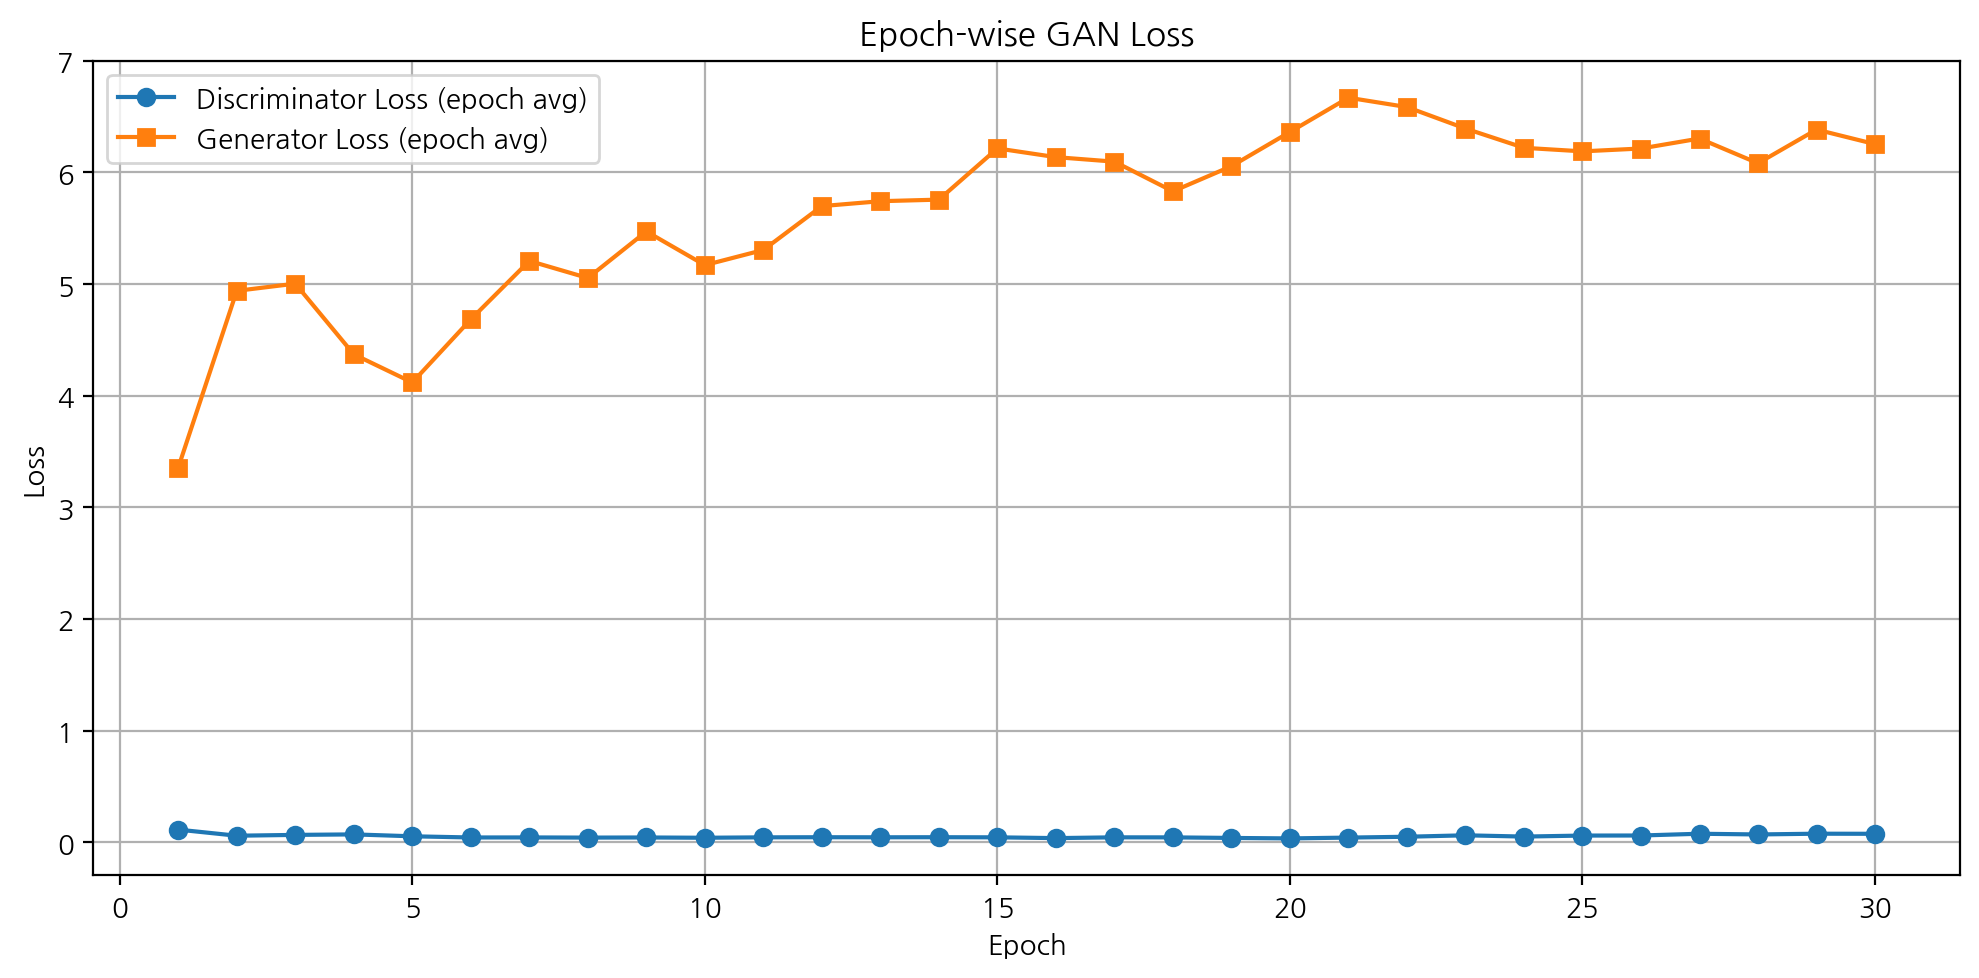

In [ ]:
# -------------------- 9. 손실값 데이터 시각화 --------------------
# 에폭 평균 손실값을 시각화하는 함수 정의
def plot_epoch_losses(d_losses, g_losses):
    plt.figure(figsize=(10, 5))

    # 에폭 인덱스를 1부터 시작하도록 수정
    epochs = range(1, len(d_losses) + 1)
    # 에폭별 판별자 손실값 그래프
    plt.plot(epochs, d_losses, label='Discriminator Loss (epoch avg)', marker='o')
    # 에폭별 생성자 손실값 그래프
    plt.plot(epochs, g_losses, label='Generator Loss (epoch avg)', marker='s')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch-wise GAN Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 실제 손실값 리스트를 받아 그래프 출력
plot_epoch_losses(callback.epoch_d_losses, callback.epoch_g_losses)

### 생성자와 판별자의 손실 값 변화 분석
- 판별자가 너무 강해서 생성자가 전혀 학습되지 못하는 상태

| 손실 항목      | 이상적 변화(정확한 표현)            | 현재 DNN-GAN의 모습 | 해석                  |
| :--------- | :------------------------ | :------------- | :------------------ |
| **d_loss** | 처음 낮아지다 다시 안정적 진동 (균형 유지) | 낮고 고정          | 판별자가 너무 강함 |
| **g_loss** | 점점 낮아지며 안정적 진동            | 점점 높아짐         | 생성자가 개선되지 못함, 즉 생성자는 진짜처럼 만들지 못함        |

- 이상적 패턴 변화와 비교

| 항목         | 이상적 패턴                       | 현재 그래프          |
| :--------- | :--------------------------- | :-------------- |
| **d_loss** | 초기에 낮았다가 진동하며 0.3~1.0 근처 유지  | 거의 0 고정         |
| **g_loss** | 점차 감소하며 진동                   | 5~6 수준에서 높고 불안정 |
| **결론**     | 경쟁적 균형 (dynamic equilibrium) | 판별자 독주 상태       |


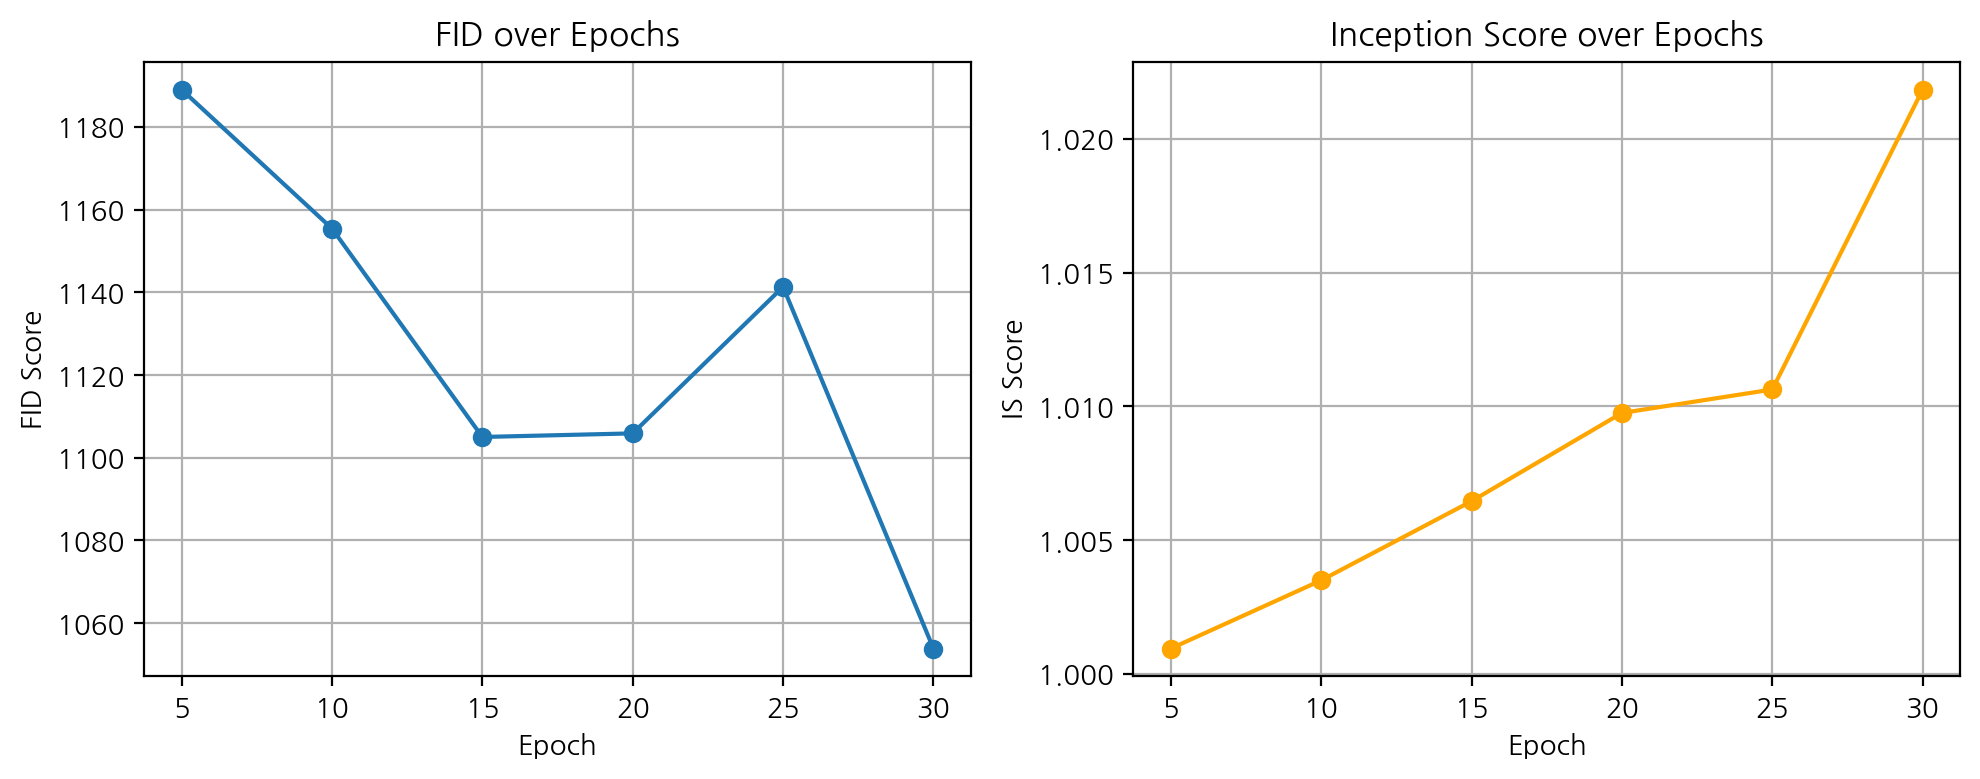

In [ ]:
# -------------------- 10. 평가지표 FID / IS 데이터 시각화 --------------------
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(5, 5 * len(callback.fid_scores) + 1, 5), callback.fid_scores, marker='o')
plt.title("FID over Epochs")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(5, 5 * len(callback.is_scores) + 1, 5), callback.is_scores, marker='o', color='orange')
plt.title("Inception Score over Epochs")
plt.xlabel("Epoch")
plt.ylabel("IS Score")
plt.grid(True)

plt.tight_layout()
plt.show()

### FID와 IS 분석

| 지표      | 이상적 값               | 좋음의 의미                   | 나쁨의 의미            |
| :------ | :------------------ | :----------------------- | :---------------- |
| **FID** | 0 (낮을수록 좋음)         | 생성 이미지가 실제 데이터 분포와 거의 동일 | 이미지 품질 낮거나 다양성 부족 |
| **IS**  | 높을수록 좋음 (10 이상 이상적) | 생성 이미지가 명확하고 다양한 클래스 포함  | 이미지 모호하거나 단조로움    |

### FID와 IS 분석 기분
- "FID는 낮을수록 좋고, IS는 높을수록 좋다”

| 구분                   | **FID (Fréchet Inception Distance)** | **IS (Inception Score, CIFAR-10 기준)** | **해석 / 품질 평가**                             |
| :------------------- | :----------------------------------: | :-----------------------------------: | :----------------------------------------- |
| **이상적 목표**           |                 **0**                |               **10 이상**               | 완벽에 가까움 — 진짜 이미지와 거의 구분 불가                 |
| **매우 우수**            |               < **10**               |              **9~10 이상**              | 매우 사실적이고 다양함 (SOTA 수준: BigGAN, StyleGAN 등) |
| **양호**               |               **10~30**              |                **8~9**                | 적당히 진짜 같음, 품질 괜찮음 (Improved GAN 수준)        |
| **보통**               |               **30~50**              |                **6~8**                | 인공적인 느낌 있음 (DCGAN 수준)                      |
| **품질 낮음**            |               > **50**               |                 **<6**                | 노이즈 많고 다양성 부족, 학습 불안정                      |
| **참고값 (Real Image)** |                   —                  |            **≈ 11.2 ± 0.1**           | 실제 데이터셋 기준 최고 점수                           |


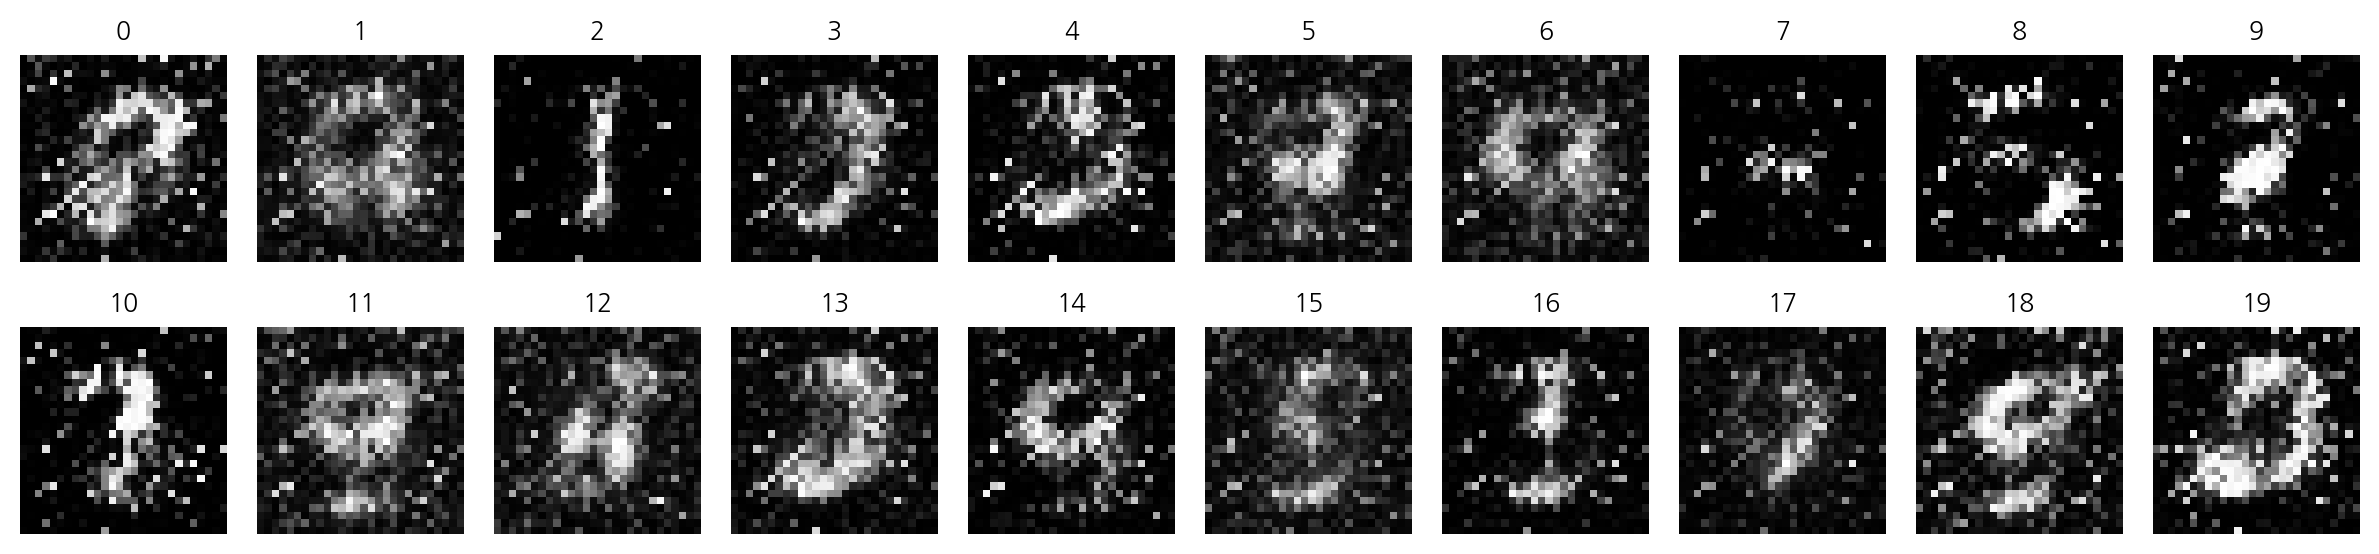

In [ ]:
# -------------------- 11. 최종 이미지 20개 데이터 시각화 --------------------
def show_generated_images(model):
    # 100차원 랜덤 노이즈 20개 생성
    seed = tf.random.normal([20, 100])

    # 생성자를 통해 이미지 생성
    predictions = model(seed, training=False)
    # [-1, 1] 범위를 [0, 1]로 정규화 (시각화를 위해)
    predictions = (predictions + 1.0) / 2.0

    # 2행 10열 subplot 구성 (총 20개 이미지 모두 표시)
    fig = plt.figure(figsize=(12, 3))
    for i in range(20):
        # subplot 배치: 2행 10열, 인덱스는 1부터 시작
        plt.subplot(2, 10, i+1)
        # 이미지 출력 (28x28 흑백 이미지)
        plt.imshow(predictions[i].numpy().reshape(28, 28), cmap='gray')
        # 인덱스 번호를 제목으로 표시
        plt.title(str(i), fontsize=9)
        # 축 눈금 제거
        plt.axis('off')

    # subplot 레이아웃 간격 자동 조절
    plt.tight_layout()
    # 그래프 출력
    plt.show()

# 최종 이미지 시각화 함수 호출
show_generated_images(generator)

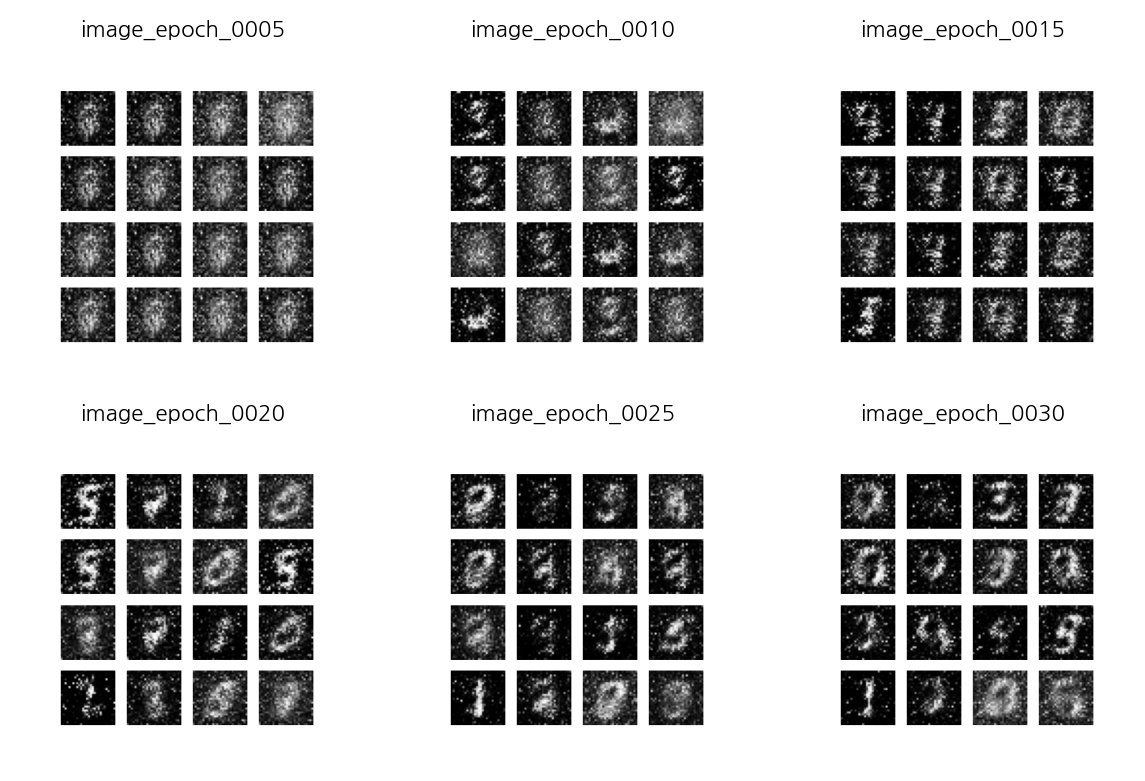

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# -------------------- 12. 저장된 이미지 파일 순차 출력 함수 --------------------
def show_saved_generated_images(folder='generated', cols=3):
    """
    지정된 폴더에 저장된 이미지들을 epoch 순서대로 불러와 출력.

    Args:
        folder (str): 이미지가 저장된 폴더명
        cols (int): 가로에 출력할 이미지 수
    """
    # 파일명 정렬
    files = sorted(
        [f for f in os.listdir(folder) if f.endswith('.png')],
        key=lambda x: int(x.split('_')[-1].split('.')[0])
    )

    # 이미지 개수 및 행 계산
    num_images = len(files)
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(cols * 2, rows * 2)) # (6, 4)

    for i, filename in enumerate(files):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(filename.split('.')[0], fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_saved_generated_images()

## 전체 코드

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - d_loss: 0.1263 - g_loss: 3.1160
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - d_loss: 0.0795 - g_loss: 4.6838
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - d_loss: 0.0824 - g_loss: 4.2797
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - d_loss: 0.0666 - g_loss: 4.2472
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - d_loss: 0.0404 - g_loss: 5.0111
Epoch 5 - FID: 1218.58 | IS: 1.00
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - d_loss: 0.0404 - g_loss: 5.0115
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - d_loss: 0.0484 - g_loss: 4.2465
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - d_loss: 0.0442 - g_loss: 4.4480
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - d_loss: 0.0455 - g_loss: 4.6731
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - d_loss: 0.0520 - g_loss: 5.0080
Epoch 10/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - d_loss: 0.0554 - g_loss: 5.1141
Epoch 10 -

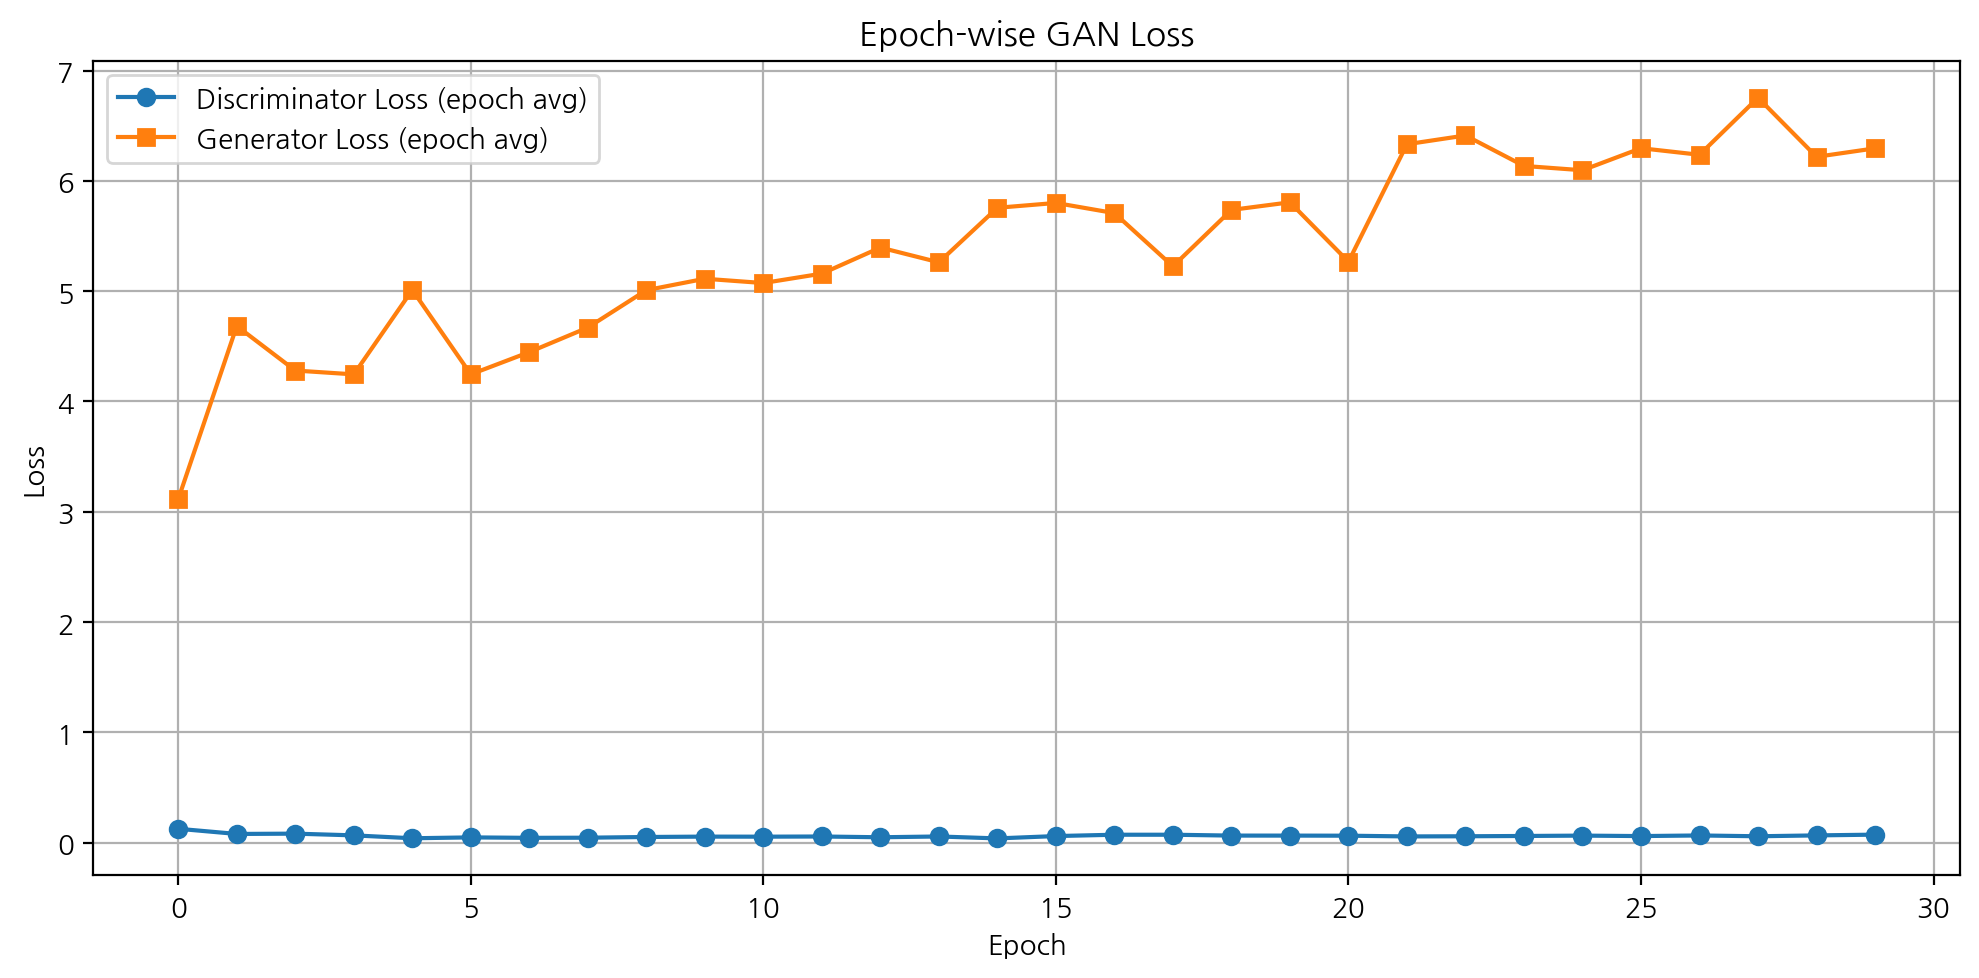

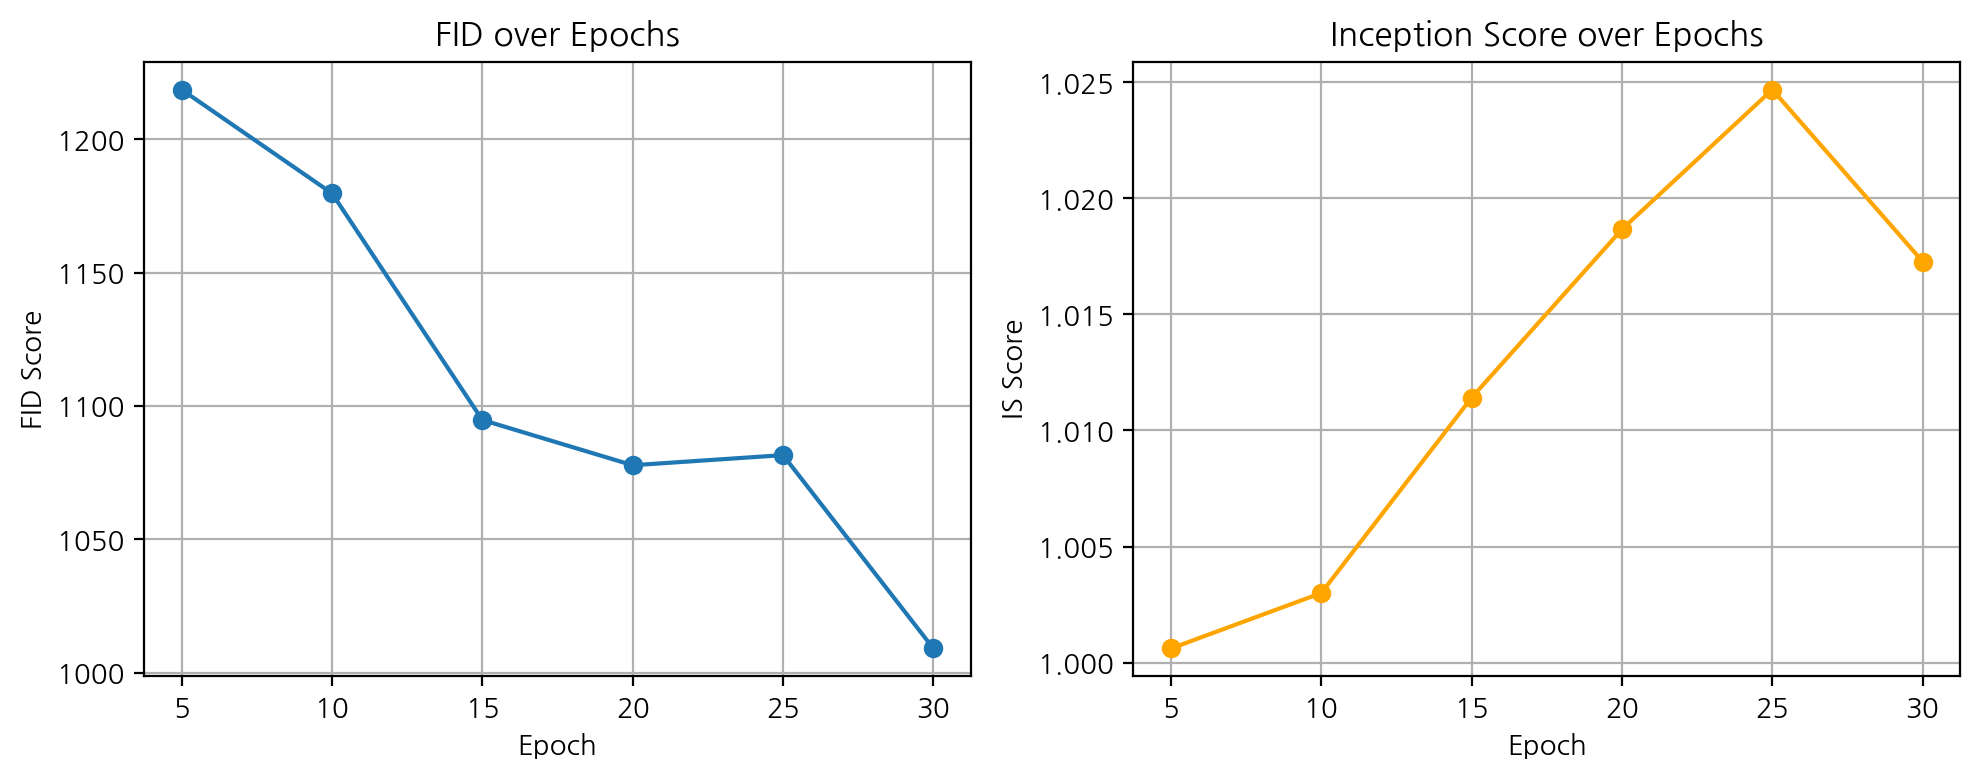

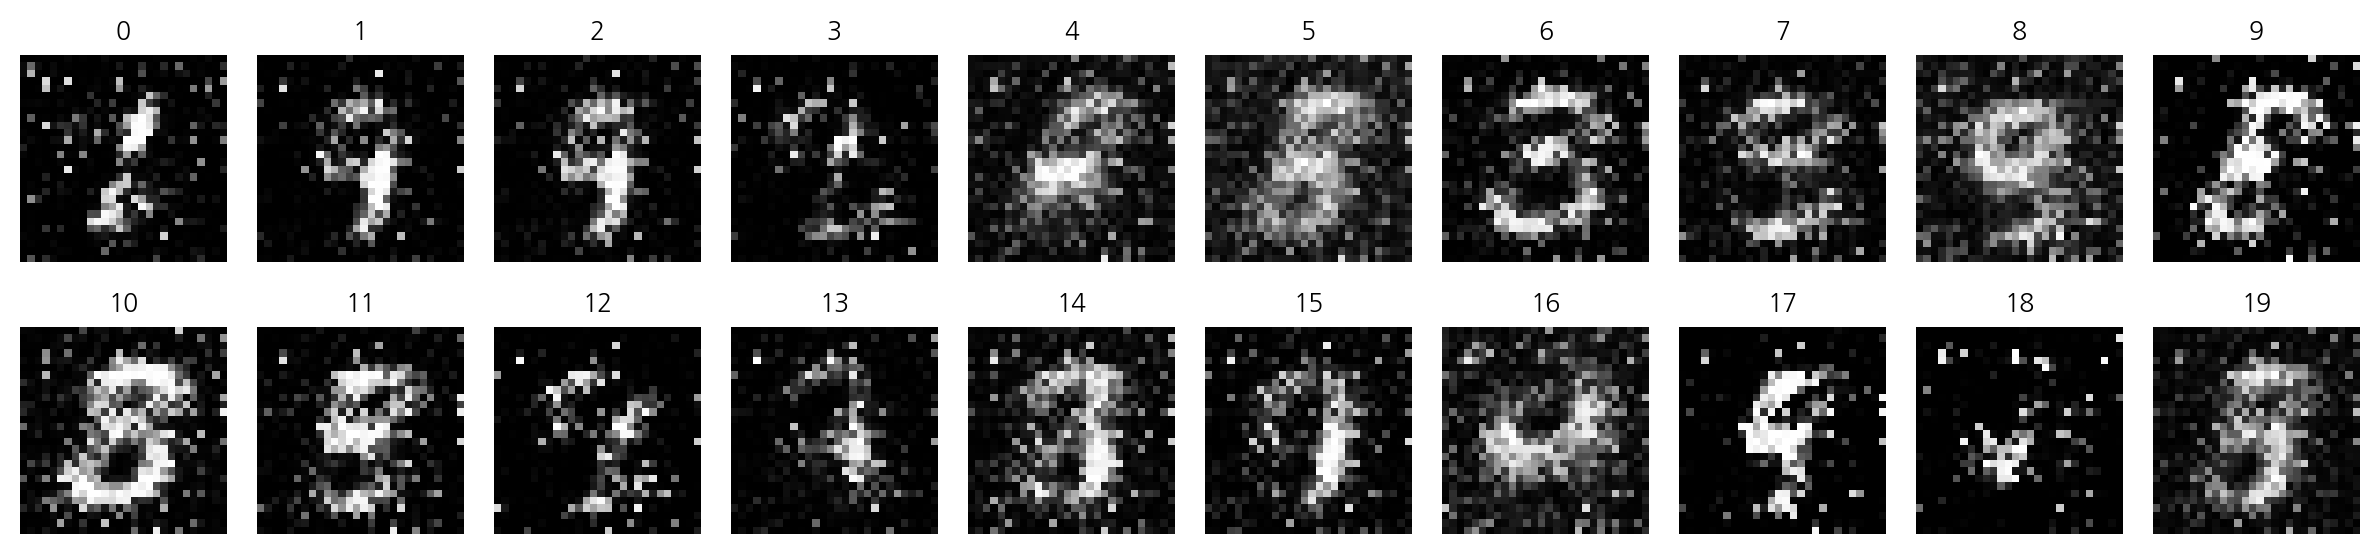

In [ ]:
# -------------------- 1. 라이브러리 로딩 --------------------
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import tensorflow_probability as tfp

# -------------------- 2. 데이터 준비 --------------------
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32") - 127.5) / 127.5
x_train = x_train.reshape((-1, 784))
BUFFER_SIZE = 60000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# -------------------- 3. 모델 정의 --------------------
def make_generator_model():
    return tf.keras.Sequential([
        tf.keras.Input(shape=(100,)), # 명시적 Input layer
        layers.Dense(256, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(784, activation='tanh') # 출력은 784 = 28x28
    ])

def make_discriminator_model():
    return tf.keras.Sequential([
        tf.keras.Input(shape=(784,)), # 명시적 Input layer
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid') # 출력은 실수 하나 (진짜/가짜 확률)
    ])

# -------------------- 4. FID / IS 계산 --------------------
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))

def get_inception_features(images):
    images = tf.image.resize(images, [75, 75])
    images = preprocess_input(images)
    return inception(images, training=False)

def calculate_fid(real_images, fake_images):
    # InceptionV3 특성 추출
    act1 = get_inception_features(real_images)
    act2 = get_inception_features(fake_images)

    # 평균 및 공분산 계산
    mu1, sigma1 = tf.reduce_mean(act1, axis=0), tfp.stats.covariance(act1)
    mu2, sigma2 = tf.reduce_mean(act2, axis=0), tfp.stats.covariance(act2)
    # 평균 차이의 제곱합 (Euclidean 거리)
    ssdiff = tf.reduce_sum(tf.square(mu1 - mu2))

    # 수치 안정성을 위해 아주 작은 값 더하기
    eps = 1e-6
    sigma1 += eps * tf.eye(sigma1.shape[0])
    sigma2 += eps * tf.eye(sigma2.shape[0])
    # 행렬 곱의 제곱근 계산
    covmean = sqrtm((sigma1 @ sigma2).numpy())
    # 복소수 값이 나올 경우 실수 부분만 사용
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # FID 계산: 평균 거리 + 공분산 trace 거리
    fid = ssdiff + tf.linalg.trace(sigma1 + sigma2 - 2 * tf.convert_to_tensor(covmean))

    return fid

def calculate_inception_score(images, splits=10):
    preds = tf.nn.softmax(get_inception_features(images))
    scores = []
    N = preds.shape[0]
    for i in range(splits):
        part = preds[i * N // splits: (i + 1) * N // splits]
        py = tf.reduce_mean(part, axis=0)
        kl = part * (tf.math.log(part + 1e-10) - tf.math.log(py + 1e-10))
        kl_sum = tf.reduce_mean(tf.reduce_sum(kl, axis=1))
        scores.append(tf.exp(kl_sum).numpy())
    return np.mean(scores)

# -------------------- 5. GAN 클래스 정의 --------------------
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super().compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal([batch_size, 100])

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise)
            real_logits = self.discriminator(real_images)
            fake_logits = self.discriminator(fake_images)
            d_loss_real = self.loss_fn(tf.ones_like(real_logits), real_logits)
            d_loss_fake = self.loss_fn(tf.zeros_like(fake_logits), fake_logits)
            d_loss = (d_loss_real + d_loss_fake) / 2
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        noise = tf.random.normal([batch_size, 100])
        with tf.GradientTape() as tape:
            fake_images = self.generator(noise)
            fake_logits = self.discriminator(fake_images)
            g_loss = self.loss_fn(tf.ones_like(fake_logits), fake_logits)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

# -------------------- 6. 5 에폭마다 생성된 이미지 저장 함수 --------------------
def generate_and_save_images(model, epoch, seed):
    # 고정된 latent seed로 Generator에서 이미지 생성
    predictions = model(seed, training=False)
    # 생성 이미지의 픽셀값을 [-1, 1] → [0, 1] 범위로 정규화 (시각화용)
    predictions = (predictions + 1) / 2.0

    # 4x4 그리드 형태의 이미지 출력을 위한 figure 객체 생성
    fig = plt.figure(figsize=(4, 4))
    # 생성된 각 이미지를 서브플롯에 하나씩 출력
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)  # 4행 4열 중 i+1 번째 위치에 이미지 배치
        # 28x28 이미지로 reshape, 흑백 표시
        plt.imshow(predictions[i].numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')  # 축 눈금 숨기기

    # 저장 폴더가 없으면 생성
    os.makedirs("generated", exist_ok=True)
    # 이미지 저장: 에폭 번호를 네 자리로 표현하여 파일 이름 지정
    plt.savefig(f"generated/image_epoch_{epoch:04d}.png")
    # 현재 figure 객체 닫기 (메모리 누수 방지)
    plt.close()


# -------------------- 7. 콜백 정의 --------------------
class ImageEvalCallback(tf.keras.callbacks.Callback):
    def __init__(self, generator, seed, real_images):
        # 생성된 이미지를 평가할 Generator 모델
        self.generator = generator
        # 고정된 노이즈 벡터 (이미지 생성 consistency 확보용)
        self.seed = seed
        # 실제 이미지 샘플 (FID 계산 시 사용)
        self.real_images = real_images
        # 에폭별 FID 점수를 저장할 리스트
        self.fid_scores = []
        # 에폭별 IS (Inception Score)를 저장할 리스트
        self.is_scores = []
        # 에폭 단위 Discriminator 손실값 저장 리스트
        self.epoch_d_losses = []
        # 에폭 단위 Generator 손실값 저장 리스트
        self.epoch_g_losses = []
        # 현재 에폭에서 배치마다 누적되는 Discriminator 손실 (평균 내기 위함)
        self._temp_d_losses = []
        # 현재 에폭에서 배치마다 누적되는 Generator 손실 (평균 내기 위함)
        self._temp_g_losses = []

    def on_train_batch_end(self, batch, logs=None):
        if logs:
            self._temp_d_losses.append(logs["d_loss"])
            self._temp_g_losses.append(logs["g_loss"])

    def on_epoch_end(self, epoch, logs=None):
        mean_d = np.mean(self._temp_d_losses)
        mean_g = np.mean(self._temp_g_losses)
        self.epoch_d_losses.append(mean_d)
        self.epoch_g_losses.append(mean_g)
        self._temp_d_losses.clear()
        self._temp_g_losses.clear()

        if (epoch + 1) % 5 == 0:
            generate_and_save_images(self.generator, epoch + 1, self.seed)
            fake_images = self.generator(self.seed, training=False)
            real_sample = tf.convert_to_tensor(self.real_images[:16])
            real_rgb = tf.image.grayscale_to_rgb(tf.reshape(real_sample, [-1, 28, 28, 1]))
            fake_rgb = tf.image.grayscale_to_rgb(tf.reshape((fake_images + 1) / 2.0, [-1, 28, 28, 1]))
            fid = calculate_fid(real_rgb, fake_rgb).numpy()
            inc = calculate_inception_score(fake_rgb)
            self.fid_scores.append(fid)
            self.is_scores.append(inc)
            print(f"\nEpoch {epoch+1} - FID: {fid:.2f} | IS: {inc:.2f}")

# -------------------- 8. 훈련 --------------------
generator = make_generator_model()
discriminator = make_discriminator_model()
gan = GAN(generator, discriminator)

gan.compile(
    g_optimizer=tf.keras.optimizers.Adam(1e-4),
    d_optimizer=tf.keras.optimizers.Adam(1e-4),
    loss_fn=tf.keras.losses.BinaryCrossentropy()
)

seed = tf.random.normal([16, 100])
callback = ImageEvalCallback(generator, seed, x_train)

gan.fit(train_dataset, epochs=30, callbacks=[callback])

# -------------------- 9. 그래프 시각화 --------------------
def plot_epoch_losses(d_losses, g_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss (epoch avg)', marker='o')
    plt.plot(g_losses, label='Generator Loss (epoch avg)', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch-wise GAN Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_epoch_losses(callback.epoch_d_losses, callback.epoch_g_losses)

# -------------------- 10. 평가지표 FID / IS 데이터 시각화 --------------------
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(5, 5 * len(callback.fid_scores) + 1, 5), callback.fid_scores, marker='o')
plt.title("FID over Epochs")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(5, 5 * len(callback.is_scores) + 1, 5), callback.is_scores, marker='o', color='orange')
plt.title("Inception Score over Epochs")
plt.xlabel("Epoch")
plt.ylabel("IS Score")
plt.grid(True)

plt.tight_layout()
plt.show()

# -------------------- 11. 최종 이미지 20개 데이터 시각화 --------------------
def show_generated_images(model):
    # 100차원 랜덤 노이즈 20개 생성
    seed = tf.random.normal([20, 100])

    # 생성자를 통해 이미지 생성
    predictions = model(seed, training=False)
        # [-1, 1] 범위를 [0, 1]로 정규화 (시각화를 위해)
    predictions = (predictions + 1.0) / 2.0

    # 2행 10열 subplot 구성 (총 20개 이미지 모두 표시)
    fig = plt.figure(figsize=(12, 3))
    for i in range(20):
        # subplot 배치: 2행 10열, 인덱스는 1부터 시작
        plt.subplot(2, 10, i+1)
        # 이미지 출력 (28x28 흑백 이미지)
        plt.imshow(predictions[i].numpy().reshape(28, 28), cmap='gray')
        # 인덱스 번호를 제목으로 표시
        plt.title(str(i), fontsize=9)
        # 축 눈금 제거
        plt.axis('off')

    # subplot 레이아웃 간격 자동 조절
    plt.tight_layout()
    # 그래프 출력
    plt.show()

# 최종 이미지 시각화 함수 호출
show_generated_images(generator)

## 종료